# Regressão Polinomial

In [71]:
import pyprind
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools

from algoritmos_tensorflow.regressao import modelo_simples, gradiente

A **regressão polinomial** é um tipo de **regressão linear** em que a relação entre a variável independente (x) e a variável dependente (y) é modelada como um **polinômio** de grau (n).

A ideia é expandir o modelo linear tradicional $((y = \beta_0 + \beta_1x))$ para incluir termos com potências de $(x)$, como $(x^2, x^3, \dots, x^n)$. Assim, o modelo geral fica:

$$

y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \dots + \beta_n x^n + \varepsilon

$$

* Quando (n=1), temos a **regressão linear simples**.
* Quando (n=2), temos uma parábola.
* Para graus maiores, o modelo pode capturar relações mais complexas entre as variáveis.

 **Características principais**:

* É **linear nos parâmetros** ((\beta_i)), mesmo que seja polinomial nas variáveis.
* Útil para ajustar **curvas não lineares**.
* Deve-se ter cuidado com **overfitting**, pois polinômios de grau muito alto podem ajustar perfeitamente os dados de treino, mas generalizar mal em novos dados.



In [72]:
# Your dataset
altura      = tf.constant(
    value = [1.087, 1.613, 0.953, 1.003, 1.156, 0.978, 1.092, 0.572, 0.940, 0.597, 0.838, 1.473], 
    name  ='Altura',
    dtype = tf.float32
)
altura = tf.reshape(altura, [-1, 1])

comprimento = tf.constant(
    value = [37, 50, 34, 36, 43, 28, 37, 20, 34, 30, 38, 47], 
    name  ='Comprimento',
    dtype = tf.float32
)
comprimento = tf.reshape(comprimento, [-1, 1])

In [73]:
X_ = tf.concat([altura, comprimento], axis=1)

In [74]:
def gerar_combinacoes(X, degraus):
    l, c = X.shape

    new_x = tf.Variable(tf.ones((l, 1)), dtype=tf.float32)

    # Para cada grau será feito a poly
    for grau in range(degraus):
        # Combinacoes de grau
        combinacoes = itertools.combinations_with_replacement(range(c), grau+1)

        # Para cada combinação
        for comb in combinacoes:

            prod = tf.Variable(tf.ones((l)), dtype=tf.float32)
            for i in range(len(comb)):
                prod = tf.math.multiply(prod, X_[:, comb[i]])

            prod  = tf.reshape(prod, [-1, 1])
            new_x = tf.concat([new_x, prod], 1)

    return new_x[:, 1:]

In [75]:
x_new = gerar_combinacoes(altura, 5)

In [76]:
x_new

<tf.Tensor: shape=(12, 5), dtype=float32, numpy=
array([[ 1.087     ,  1.181569  ,  1.2843655 ,  1.3961054 ,  1.5175666 ],
       [ 1.613     ,  2.6017692 ,  4.196654  ,  6.7692027 , 10.918724  ],
       [ 0.953     ,  0.908209  ,  0.8655232 ,  0.82484365,  0.786076  ],
       [ 1.003     ,  1.006009  ,  1.009027  ,  1.0120541 ,  1.0150902 ],
       [ 1.156     ,  1.336336  ,  1.5448045 ,  1.785794  ,  2.064378  ],
       [ 0.978     ,  0.95648396,  0.9354413 ,  0.9148616 ,  0.8947346 ],
       [ 1.092     ,  1.192464  ,  1.3021706 ,  1.4219704 ,  1.5527916 ],
       [ 0.572     ,  0.32718402,  0.18714927,  0.10704939,  0.06123225],
       [ 0.94      ,  0.8836    ,  0.830584  ,  0.78074896,  0.733904  ],
       [ 0.597     ,  0.356409  ,  0.21277618,  0.12702738,  0.07583535],
       [ 0.838     ,  0.702244  ,  0.5884805 ,  0.49314663,  0.41325688],
       [ 1.473     ,  2.1697292 ,  3.1960113 ,  4.707725  ,  6.934479  ]],
      dtype=float32)>

In [77]:
model = modelo_simples(features=5)

In [78]:
model, perda = gradiente(x_new, altura, model, learning_rate=0.01, epochs=1000, salvar_perda=True)
model

modelo_1
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 999 - Loss: 0.00012
Total time elapsed: 00:00:01


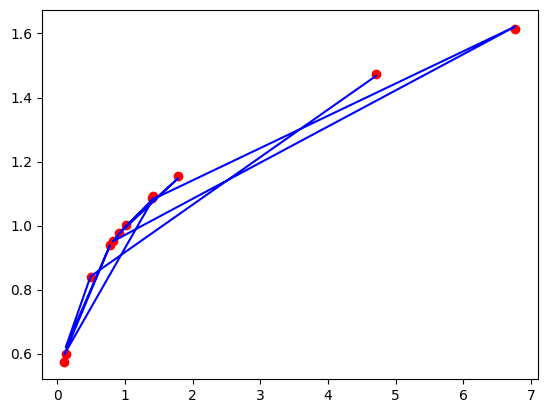

In [79]:
plt.plot(x_new[:,3], altura.numpy().flatten(), 'ro')
plt.plot(x_new[:,3], model(x_new).numpy().flatten(), 'b-')
plt.show()

&nbsp;

In [80]:
def erro_quadratico_medio(y, ypred):
    return tf.reduce_mean((y - ypred)**2)

&nbsp;

---------------------


## Regularização

* Generalização
    * Overfitting (sobreajuste) : Ocorre quando o modelo se ajusta demasiadamente aos dados usados para encontrar seus parametros.
    * Underfitting (subajuste) : Ocorre quando o modelo não se ajusta bem aos dados de treinamento

> Ideia de evitar isso é a regularização

### L2 (Ridge)

* quanto maior o valor $\alpha$  mais proximo os parametros se aproxima de zero

$$
\sum_{d=0}^d w^2_{d}
$$

> Isso é adicionado no processo de minimização ou no OLS

### Para o Gradiente descente

```pseudo
alpha <- define (0.01 geralmente)
w_0   <- inicia aleatoriamente
w_0   <- inicia aleatoriamente
loss  <- loss_fn(ytrue, ypred) 

PARA I EM 1 ATÉ MAX_ITER:
    w_0 <- w_0 + alpha * ( E_w0 - lamdba * sum(w_0**2) ) 
    w_1 <- w_1 + alpha * E_w1

    loss <- loss_fn(ytrue, ypred) 
```

In [81]:
def gradiente(x, y, model, lambda_=0.01, learning_rate=0.01, epochs=1000, loss=erro_quadratico_medio, salvar_perda = False):
    pgbar = pyprind.ProgBar(epochs, title=model.name, monitor=True)

    perda = []

    for epoch in range(epochs):
        ypred = model(x)

        # Atualizando pesos
        # Atualizando o coeficiente : w = w + lr * np.mean((y - w * x) * x)
        model.coeficiente = model.coeficiente + learning_rate * ( tf.reduce_mean((y - ypred) * x , axis=0) * lambda_ * tf.reduce_mean(model.coeficiente**2))

        # Atualizando o intercept : w = w + lr * np.mean(y - w * x) 
        model.interceptor = model.interceptor + learning_rate * tf.reduce_mean(y - ypred)

        pgbar.update(1, item_id=f'Epoch {epoch} - Loss: {loss(y, ypred):.5f}')
        
        if salvar_perda:
            perda.append(loss(y, ypred))
    
    return model if not salvar_perda else (model, perda)

In [82]:
model = modelo_simples(name='gd_rigularizado')
model, perda = gradiente(altura, comprimento, model, lambda_=0.1, learning_rate=0.01, epochs=1000, salvar_perda=True)
model

gd_rigularizado
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 999 - Loss: 13.00483
Total time elapsed: 00:00:02


In [83]:
model.summary()

'Intercept: [14.19723129272461] | Coeficiente: [[21.62380027770996]]'

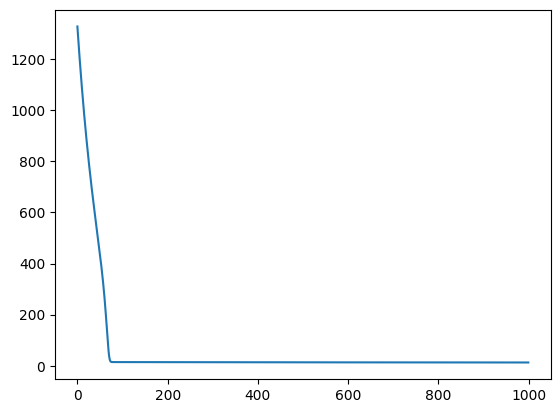

In [85]:
plt.plot(perda)

### Para SGD

```pseudo
Gradiente descendente Estocatico

alpha <- define (0.01 geralmente)
w_0   <- inicia aleatoriamente
w_0   <- inicia aleatoriamente
loss  <- loss_fn(ytrue, ypred) 

PARA I EM 1 ATÉ MAX_EPOCAS:
    XI <- X(PERMUTAÇÃO)
    YI <- Y(PERMUTAÇÃO)
    PARA J EM 1 ATÉ N_INSTANCIA:
        w_0 <- w_0 + alpha * Ei_w0 - LAMBDA * w_0**2
        w_1 <- w_1 + alpha * Ei_w1(xi)

    loss <- loss_fn(ytrue, ypred) 

```